In [10]:
import numpy as np
import nengo
import nengolib
from nengolib.signal import s

import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

from nengo_bioneurons import BahlNeuron, build_filter

In [11]:
def flat_cos(freq, t):
    T = np.pi/freq
    t_phase = np.mod(t, 4*T)
#     return np.sin(freq*t_phase)
    if 0 <= t_phase < T/2:
        return np.cos(freq*t_phase)
    elif T/2 <= t_phase < 3*T/2:
        return 0
    elif 3*T/2 <= t_phase < 5*T/2:
        return -np.cos(freq*t_phase)
    elif 5*T/2 <= t_phase < 7*T/2:
        return 0
    elif 7*T/2 <= t_phase < 4*T:
        return np.cos(freq*t_phase)
    
def ramp_flat(freq, t):
    T = 1.0/freq
    t_phase = np.mod(t, 12*T)
    if 0 <= t_phase < T:
        return freq
    elif T <= t_phase < 5*T:
        return 0
    elif 5*T <= t_phase < 7*T:
        return -freq
    elif 7*T <= t_phase <11*T:
        return 0
    elif 11*T <= t_phase < 12*T:
        return freq
    
def ramp_cos(freq, t):
    T = 1.0/freq
    t_phase = np.mod(t, 12*T)
    if 0 <= t_phase < T:
        return freq
    elif T <= t_phase < 5*T:
        return 0.1*np.cos(4*freq*t_phase)
    elif 5*T <= t_phase < 7*T:
        return -freq
    elif 7*T <= t_phase <11*T:
        return 0.1*np.cos(4*freq*t_phase)
    elif 11*T <= t_phase < 12*T:
        return freq

def make_stimulus(signal, freq, seed):       
    if signal == 'cos':
        return nengo.Node(output=lambda t: np.cos(freq*t))
    elif signal == 'sin':
        return nengo.Node(output=lambda t: np.sin(freq*t))
    elif signal == 'ramp':
        return nengo.Node(output=lambda t: freq * (t < 1.0))  # ramp for 1s, cutoff
    elif signal == 'steps':
        return nengo.Node(output=lambda t: -1*(t<1) + 1*(2<t<3) + 1*(4<t<5))
    elif signal == 'flat_cos':
        return nengo.Node(output=lambda t: flat_cos(freq, t))
    elif signal == 'ramp_flat':
        return nengo.Node(output=lambda t: ramp_flat(freq, t))
    elif signal == 'ramp_cos':
        return nengo.Node(output=lambda t: ramp_cos(freq, t))
    elif signal == 'white_noise':
        return nengo.Node(nengo.processes.WhiteSignal(
            period=100,
            high=freq,
            rms=0.5,
            seed=seed))

In [12]:
def plot_tuning_curves(
    encoders,
    xhat_pre,
    act_bio,
    n_neurons=10,
    n_eval_points=20):

    xs = []
    hz_means = []
    hz_stds = []
#     fig, ax = plt.subplots(1, 1)
    for i in range(n_neurons):  # act_bio.shape[1]
        x_dot_e = np.dot(
            xhat_pre,
            np.sign(encoders[i]))
#         x_dot_e_vals = np.linspace(
#             np.min(x_dot_e),
#             np.max(x_dot_e),
#             num=n_eval_points)
        x_dot_e_vals = np.linspace(
            -1.0,
            1.0,
            num=n_eval_points)
        Hz_mean = np.zeros((x_dot_e_vals.shape[0]))
        Hz_stddev = np.zeros_like(Hz_mean)

        for xi in range(x_dot_e_vals.shape[0] - 1):
            ts_greater = np.where(x_dot_e_vals[xi] < xhat_pre)[0]
            ts_smaller = np.where(xhat_pre < x_dot_e_vals[xi + 1])[0]
            ts = np.intersect1d(ts_greater, ts_smaller)
            if ts.shape[0] > 0: Hz_mean[xi] = np.average(act_bio[ts, i])
            if ts.shape[0] > 1: Hz_stddev[xi] = np.std(act_bio[ts, i])

        xs.append(x_dot_e_vals[:-2])
        hz_means.append(Hz_mean[:-2])
        hz_stds.append(Hz_stddev[:-2])
        
#         bioplot = ax.plot(x_dot_e_vals[:-2], Hz_mean[:-2])  # , label='%s' %i
#         ax.fill_between(x_dot_e_vals[:-2],
#             Hz_mean[:-2]+Hz_stddev[:-2],
#             Hz_mean[:-2]-Hz_stddev[:-2],
#             alpha=0.5)
#         ax.legend()
#         ax.set(xlim=((-1, 1)))
#         plt.show()
#         if np.any(Hz_mean[:-2]+Hz_stddev[:-2] > max_rate):
#             warnings.warn('warning: neuron %s over max_rate' %i)
#         if np.all(Hz_mean[:-2]+Hz_stddev[:-2] < min_rate):
#             warnings.warn('warning: neuron %s under min_rate' %i)

    return np.array(xs), np.array(hz_means), np.array(hz_stds) 

In [13]:
def simulate(
    n,
    t,
    encoders,
    gain,
    bias,
    secs,
    n_syns,
    freq,
    signal='cos',
    tau=0.1,
    bias_method='decode',
    reg=0.1,
    ns=1,
    ss=2,
    es=3,
    cs=4):

    with nengo.Network(seed=ns) as network:
        stim = make_stimulus(signal, freq, ss)
        pre = nengo.Ensemble(100, 1, neuron_type=nengo.LIF())
        bio = nengo.Ensemble(n, 1,
            encoders=encoders,
            gain=gain,
            bias=bias,
            neuron_type=BahlNeuron(bias_method=bias_method),
            seed=es,
            label='bio')
        lif = nengo.Ensemble(n, 1, neuron_type=nengo.LIF(), seed=es)

        stim_pre = nengo.Connection(stim, pre, synapse=tau)
        for sec in secs:
            nengo.Connection(pre, bio,
                             sec=sec,
                             n_syn=n_syns[sec],
                             syn_type='ExpSyn',
                             tau_list=[tau],
                             synapse=tau,
                             seed=cs)
        pre_lif = nengo.Connection(pre, lif, synapse=tau)

        network.p_stim = nengo.Probe(stim)
        network.p_pre = nengo.Probe(pre, synapse=tau)
        network.p_bio_spk = nengo.Probe(bio.neurons, 'spikes', synapse=None)
        network.p_pre_act = nengo.Probe(pre.neurons, 'spikes', synapse=tau)
        network.p_bio_act = nengo.Probe(bio.neurons, 'spikes', synapse=tau)
        network.p_lif_act = nengo.Probe(lif.neurons, 'spikes', synapse=tau)

    with nengo.Simulator(network, seed=ss) as sim:
        sim.run(t)
        
    s_bio = sim.data[network.p_bio_spk]
    a_bio = sim.data[network.p_bio_act]
    x_pre = sim.data[network.p_pre]
    encoders = sim.data[bio].encoders
    
    target = nengo.Lowpass(tau).filt(sim.data[network.p_stim])
    d_bio = nengo.solvers.LstsqL2(reg=reg)(a_bio, target)[0]
    xhat = np.dot(a_bio, d_bio)
    nrmse = nengolib.signal.nrmse(xhat, target=target)
    
    xs, hz_means, hz_stds = plot_tuning_curves(encoders, x_pre, a_bio, n_neurons=n)

    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
    rasterplot(sim.trange(), s_bio, ax=ax1)
    ax1.set(xlabel='time', ylabel='neuron')
    sns.distplot(np.ravel(a_bio), ax=ax2)
    ax2.set(xlabel='activity', ylabel='frequency')
    for ni in range(n):
        ax3.plot(xs[ni], hz_means[ni])  # , label='%s' %i
        ax3.fill_between(xs[ni],
            hz_means[ni]+hz_stds[ni],
            hz_means[ni]-hz_stds[ni],
            alpha=0.5)
    ax3.set(xlabel='$x$', ylabel='activity')
    ax4.plot(sim.trange(), xhat, label='nrmse=%.3f' %nrmse)
    ax4.set(xlabel='time', ylabel='$x$')
    plt.tight_layout()
    plt.show()

# simulate

### No gain

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:28.                                                 


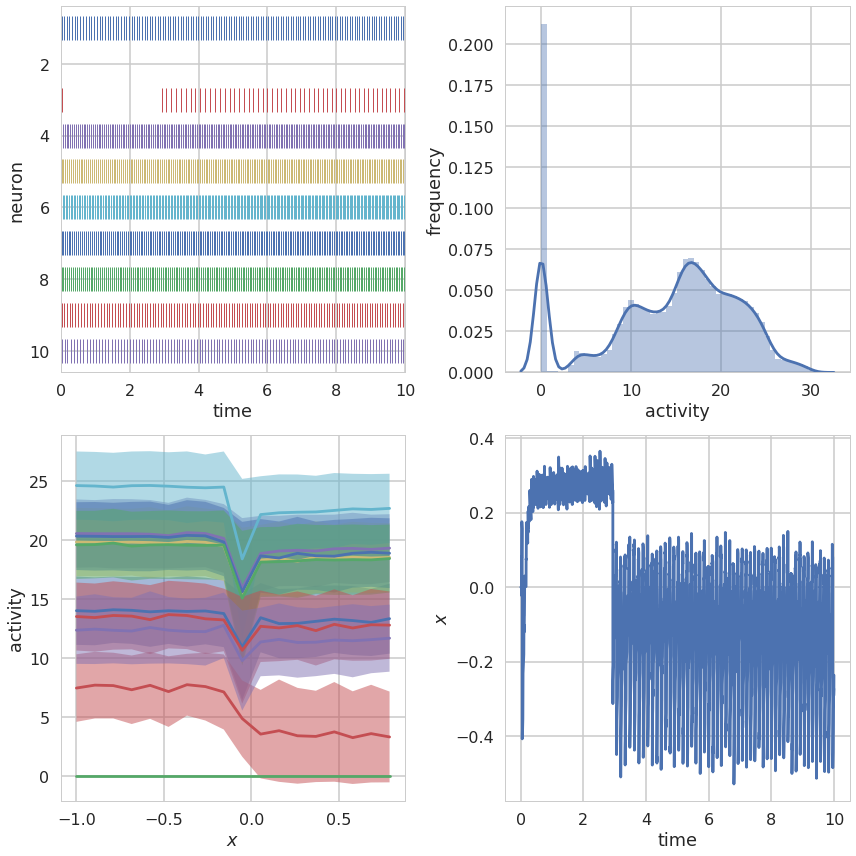

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:30.                                                 


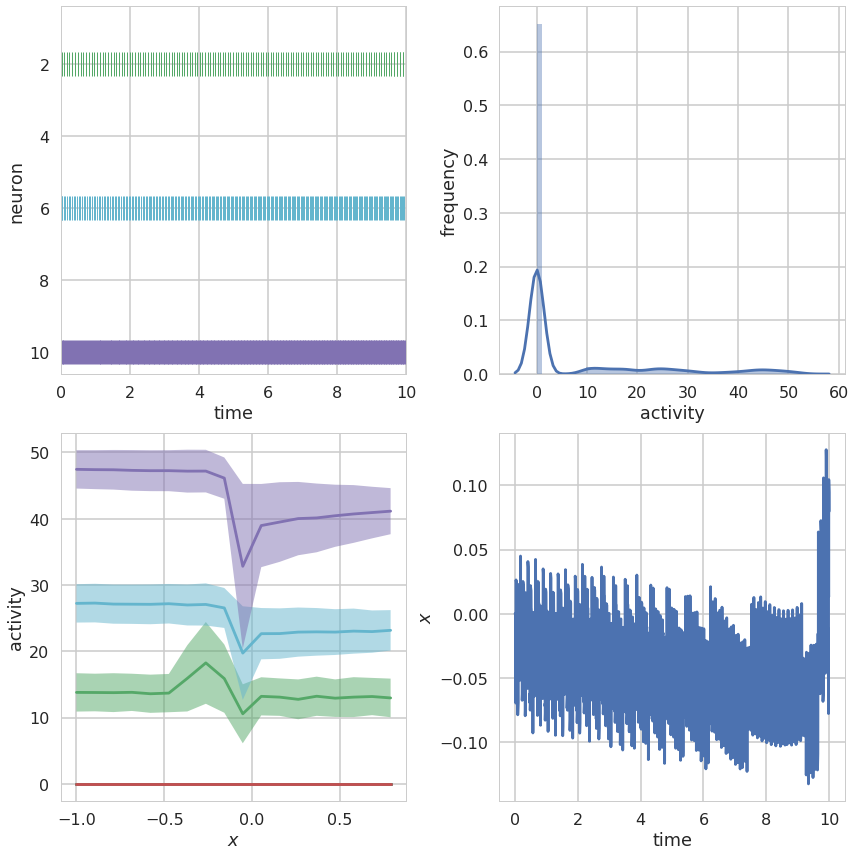

In [5]:
simulate(
    n=10,
    t=10,
    tau=0.1,
    encoders=nengo.dists.Uniform(-1e0,1e0),
    gain=nengo.dists.Uniform(-0e2,0e2),
    bias=nengo.dists.Uniform(-3e-4, 3e-4),
    bias_method='weights',
    signal='sin',
    secs=['apical'],
    n_syns={'apical': 1},
    freq=0.2*np.pi,
    )

simulate(
    n=10,
    t=10,
    tau=0.1,
    encoders=nengo.dists.Uniform(-1e0,1e0),
    gain=nengo.dists.Uniform(-0e2,0e2),
    bias=nengo.dists.Uniform(-2e0,2e0),
    bias_method='decode',
    signal='sin',
    secs=['apical'],
    n_syns={'apical': 1},
    freq=0.2*np.pi,
    )

## No bias

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:30.                                                 


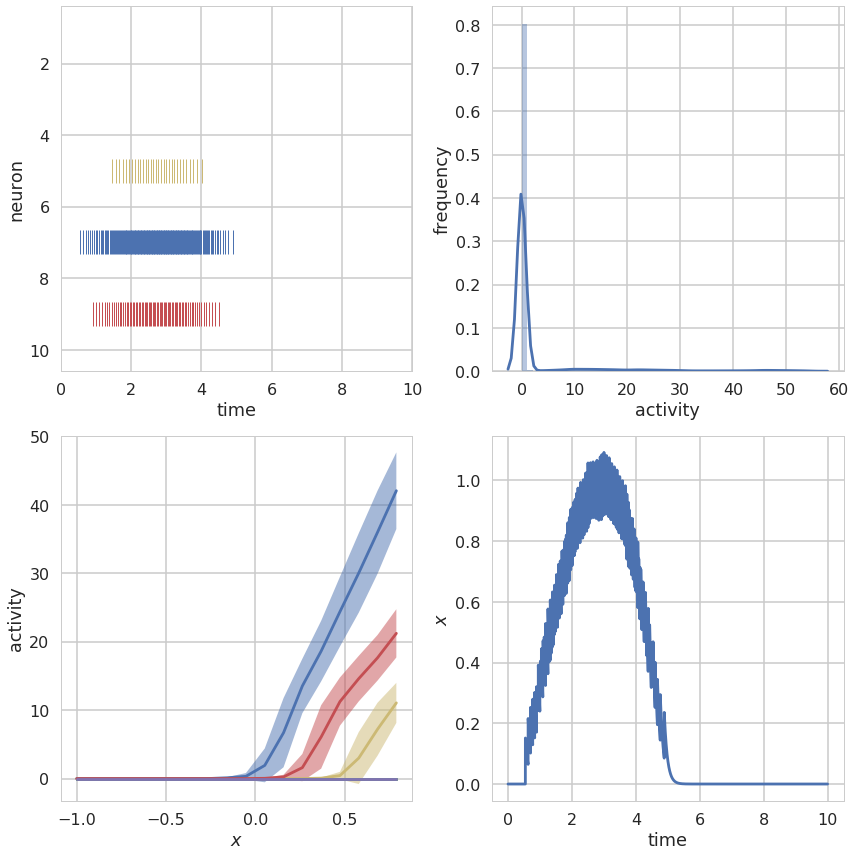

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:29.                                                 


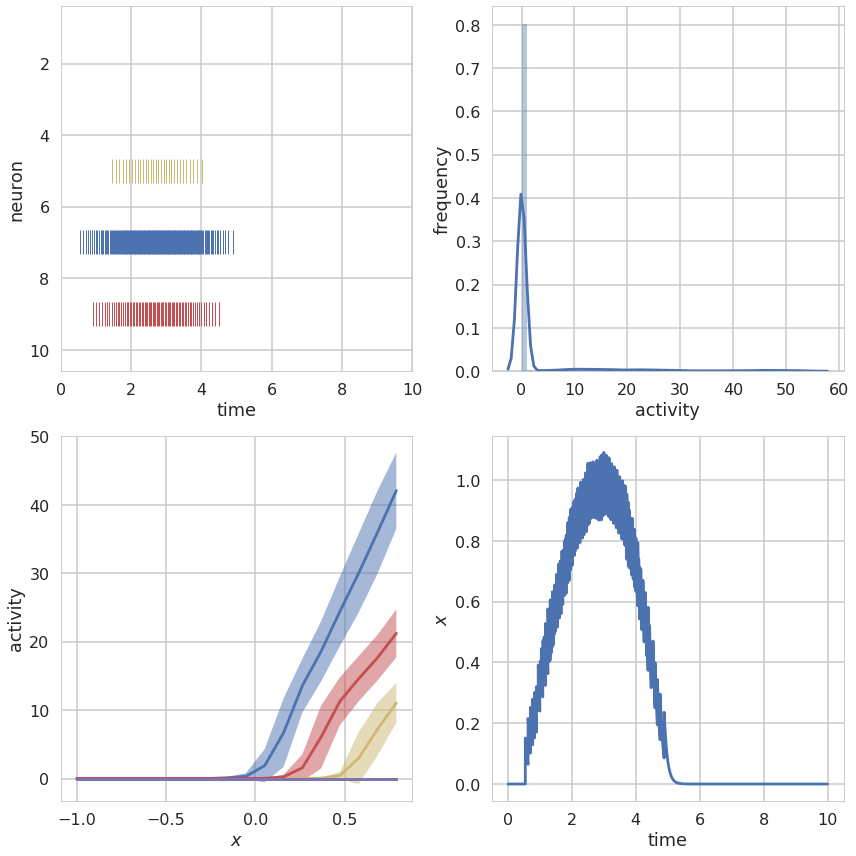

In [6]:
simulate(
    n=10,
    t=10,
    tau=0.1,
    encoders=nengo.dists.Uniform(-1e0,1e0),
    gain=nengo.dists.Uniform(-3e1,3e1),
    bias=nengo.dists.Uniform(-0e-3, 0e-3),
    bias_method='weights',
    signal='sin',
    secs=['apical'],
    n_syns={'apical': 1},
    freq=0.2*np.pi,
    )

simulate(
    n=10,
    t=10,
    tau=0.1,
    encoders=nengo.dists.Uniform(-1e0,1e0),
    gain=nengo.dists.Uniform(-3e1,3e1),
    bias=nengo.dists.Uniform(-0e1,0e1),
    bias_method='decode',
    signal='sin',
    secs=['apical'],
    n_syns={'apical': 1},
    freq=0.2*np.pi,
    )

### Gain and bias

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:29.                                                 


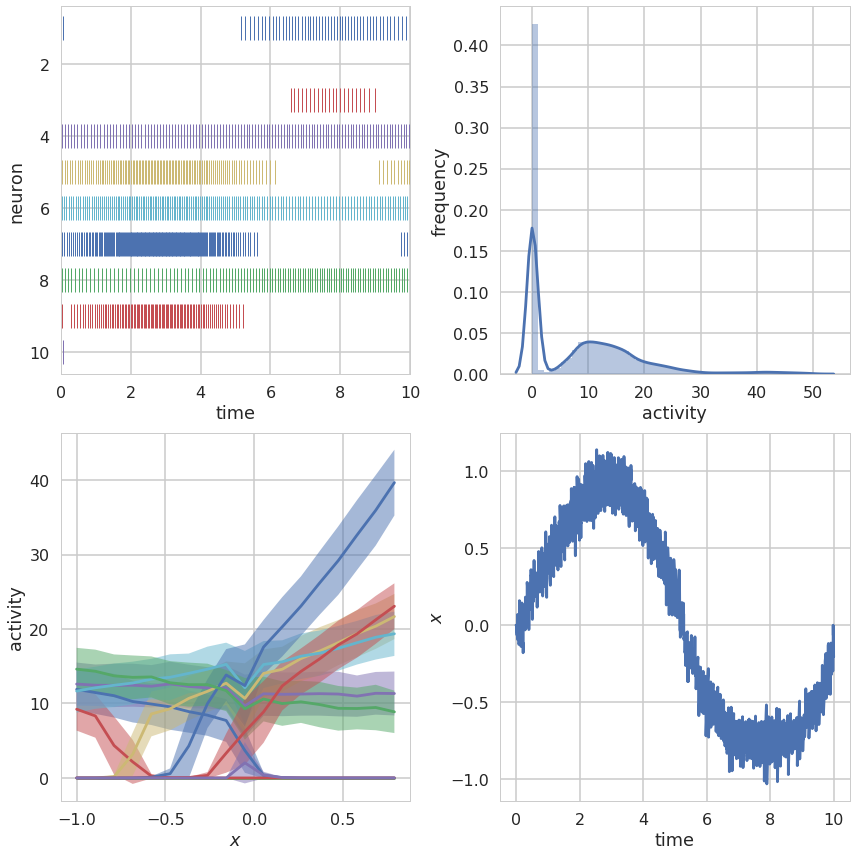

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:30.                                                 


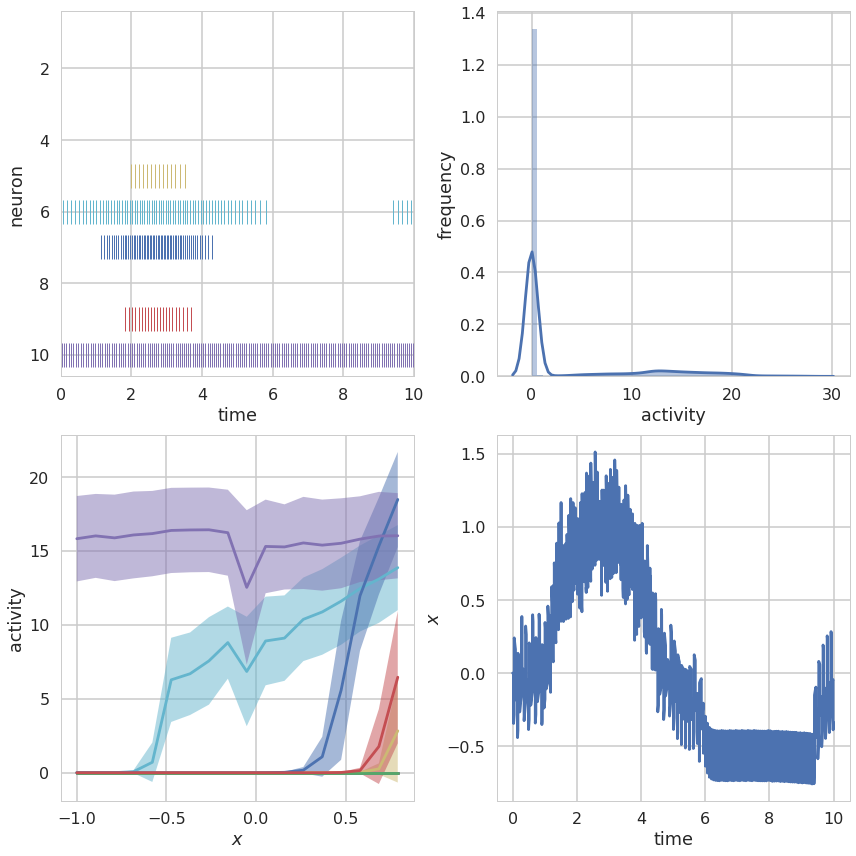

In [7]:
simulate(
    n=10,
    t=10.0,
    tau=0.1,
    encoders=nengo.dists.Uniform(-1e0,1e0),
    gain=nengo.dists.Uniform(-2e1,2e1),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    bias_method='weights',
    signal='sin',
    secs=['apical'],
    n_syns={'apical': 1},
    freq=0.2*np.pi,
    )

simulate(
    n=10,
    t=10,
    tau=0.1,
    encoders=nengo.dists.Uniform(-1e0,1e0),
    gain=nengo.dists.Uniform(-2e1,2e1),
    bias=nengo.dists.Uniform(-1e0,1e0),
    bias_method='decode',
    signal='sin',
    secs=['apical'],
    n_syns={'apical': 1},
    freq=0.2*np.pi,
    )

### Tuft connection

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:29.                                                 


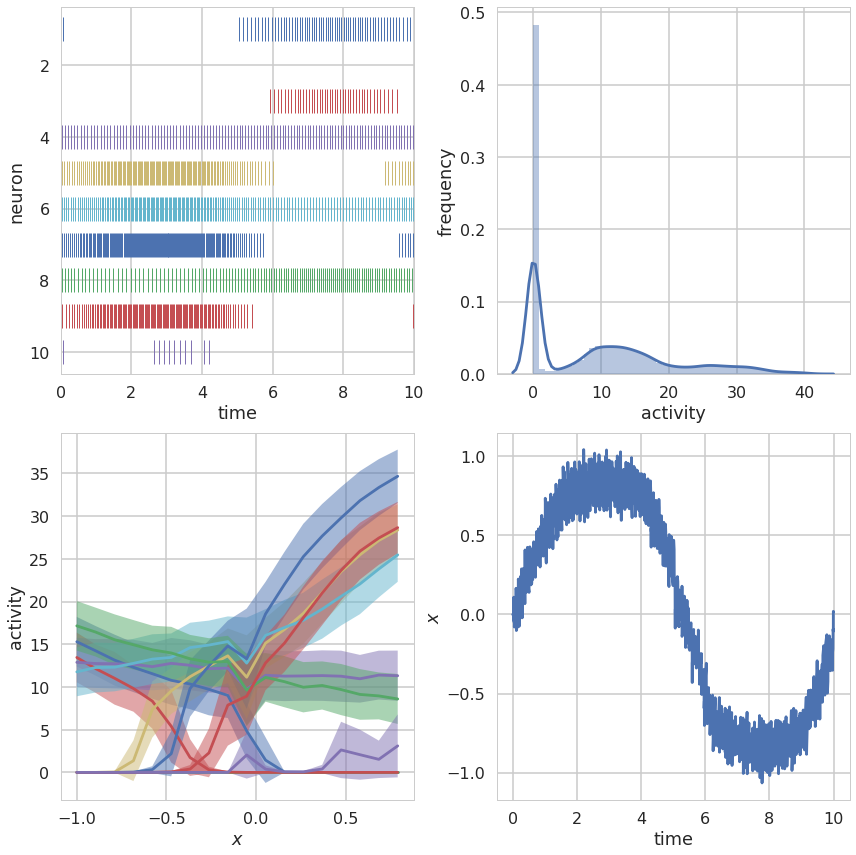

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:31.                                                 


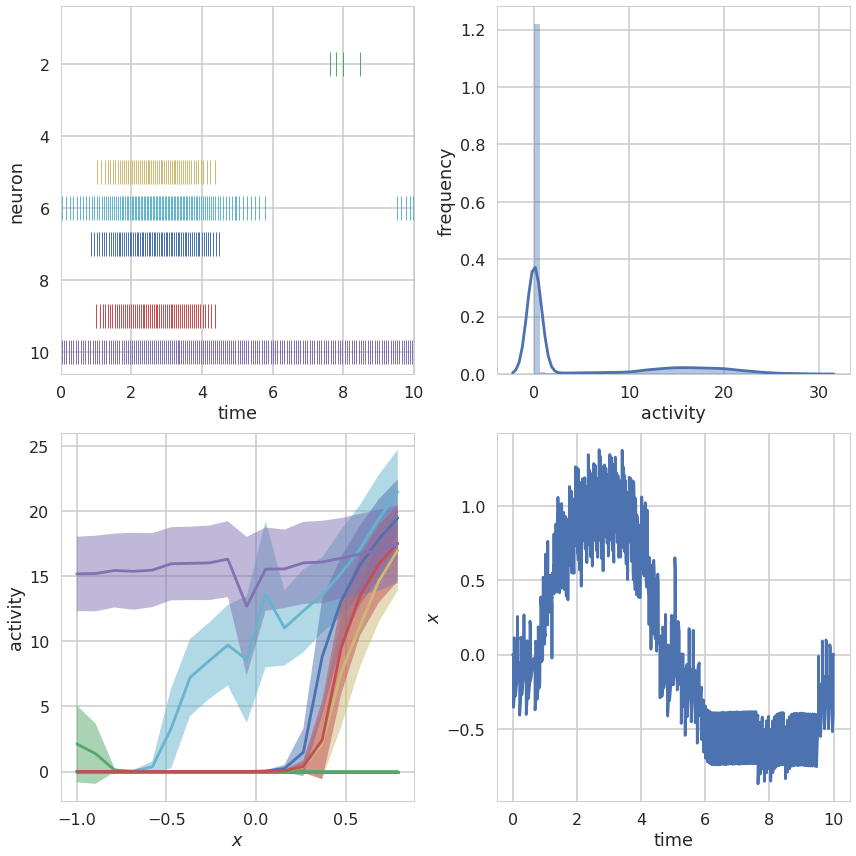

In [8]:
simulate(
    n=10,
    t=10,
    tau=0.1,
    encoders=nengo.dists.Uniform(-1e0,1e0),
    gain=nengo.dists.Uniform(-5e1,5e1),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    bias_method='weights',
    signal='sin',
    secs=['tuft'],
    n_syns={'tuft': 1},
    freq=0.2*np.pi,
    )

simulate(
    n=10,
    t=10,
    tau=0.1,
    encoders=nengo.dists.Uniform(-1e0,1e0),
    gain=nengo.dists.Uniform(-5e1,5e1),
    bias=nengo.dists.Uniform(-1e0,1e0),
    bias_method='decode',
    signal='sin',
    secs=['tuft'],
    n_syns={'tuft': 1},
    freq=0.2*np.pi,
    )

Building finished in 0:00:01.                                                   
Simulating finished in 0:04:17.                                                 


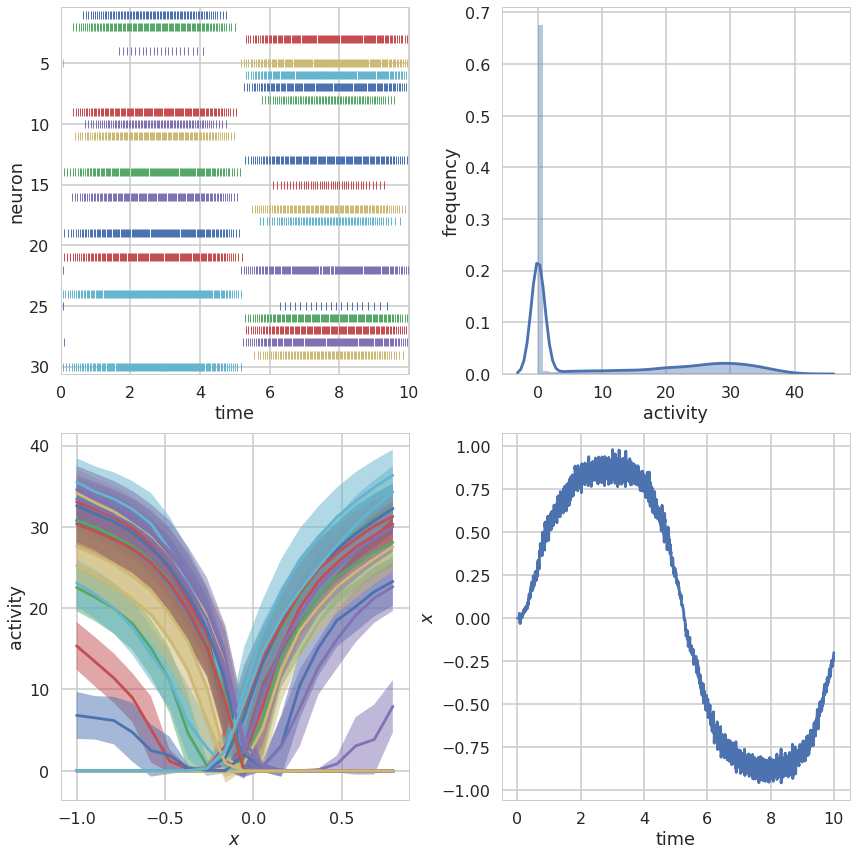

In [17]:
simulate(
    n=30,
    t=10,
    tau=0.1,
    encoders=nengo.dists.Uniform(-1e0,1e0),
    gain=nengo.dists.Uniform(-3e2,3e2),
    bias=nengo.dists.Uniform(-1e-4, 1e-4),
    bias_method='weights',
    signal='sin',
    secs=['tuft'],
    n_syns={'tuft': 1},
    freq=0.2*np.pi,
    )

Building finished in 0:00:01.                                                   
Simulating finished in 0:04:19.                                                 


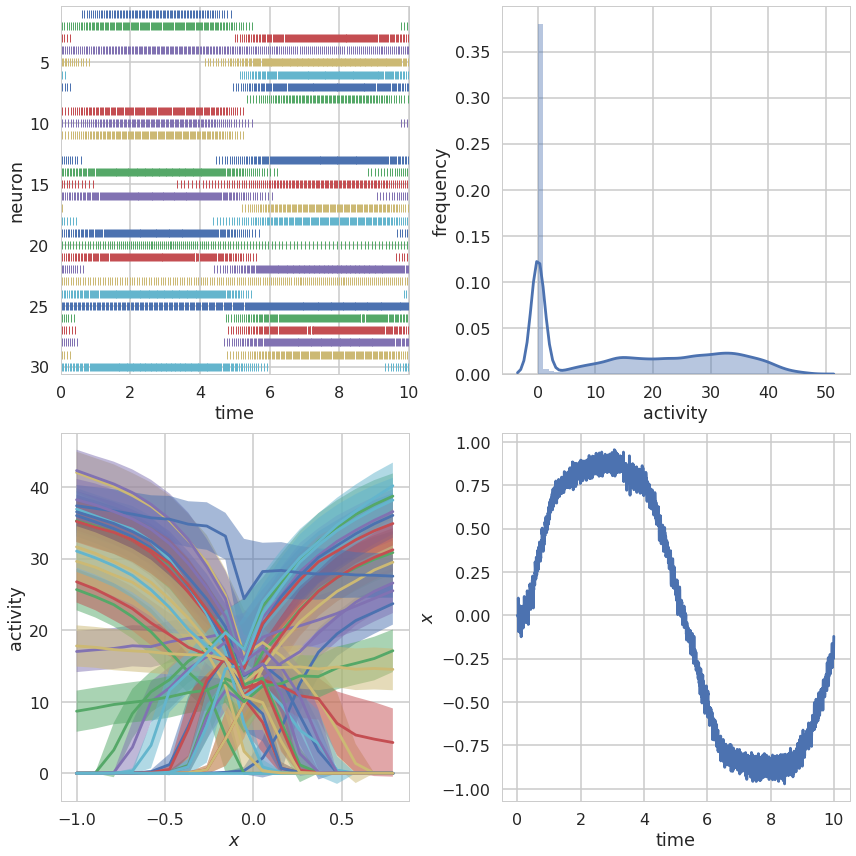

In [19]:
simulate(
    n=30,
    t=10,
    tau=0.1,
    encoders=nengo.dists.Uniform(-1e0,1e0),
    gain=nengo.dists.Uniform(-3e2,3e2),
    bias=nengo.dists.Uniform(-3e-4, 3e-4),
    bias_method='weights',
    signal='sin',
    secs=['tuft'],
    n_syns={'tuft': 1},
    freq=0.2*np.pi,
    )